In the previous post, I showed how to build a number of bayesian regression models around the classic OC4 algorithm for estimating chlorophyll concentration from remote sensing reflectance data.

In this post I will introduce several concepts including
* varying effects
* hierarchical models sometimes referred to as partial pooling
* gaussian processes to introduce inference on potential covariance between unobserved variables (parameters).

Hierarchical modeling refers to the fact that the inference is conducted on multiple levels. The hierarchical structure is based on the notion that the data can be grouped into different clusters. The coefficients relevant to each cluster will have their own priors, drawn from a common set of *hyper priors*.

In [1]:
# Importing libraries
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import pickle
import theano.tensor as tt
from IPython.core.display import display, HTML

In [2]:
# Setting graphics...
% matplotlib inline
rc_ = {}
rc_['xtick.labelsize'] = 16
rc_['ytick.labelsize'] = 16
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 16
rc_['font.size'] = 16
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18
display(HTML("<style>.container {width: 90% !important}</style>"))
pl.style.use('bmh')

Below, I load training and testing datasets prepared and pickled earlier, in the previous post:

In [3]:
with open('./pickleJar/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)

In [4]:
df_train = datasets['swf']['train']
df_test = datasets['swf']['test']
del datasets

I'll refer to the test set at the very end. The training data set features a column titled '*maxBlueId*':

In [5]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a
0,1565,-0.267867,rrs510,1.581950
1,1566,-0.220457,rrs510,1.544192
2,1567,-0.268537,rrs510,1.429914
3,1568,-0.279976,rrs510,1.680879
4,1559,-0.167733,rrs510,1.371991


*maxBlueId* is a categorical variable that indicates which 'blue' band was used for the blue-to-green ratio; 443, 490, 510. I will use this as a clustering mechanism, and examine whether there is much difference between groups vis-a-vis chlorophyll. A first step is to repeat our previous data exploration step, with the additional maxBlueId information incorporated into the graph:

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


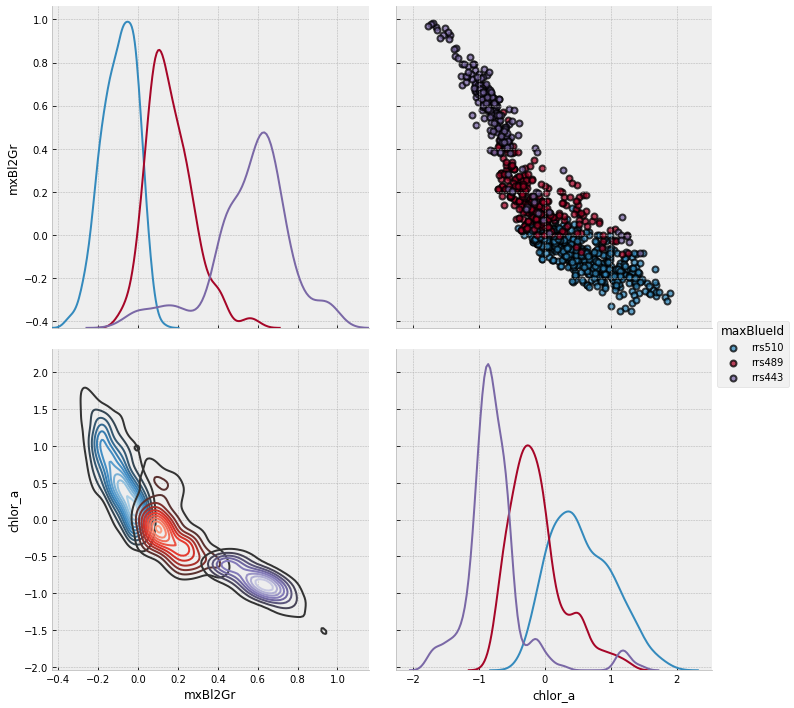

In [29]:
vars_ = ['mxBl2Gr', 'chlor_a']
g  = sb.PairGrid(df_train, vars=['mxBl2Gr', 'chlor_a'],size=5, diag_sharey=False,
                hue='maxBlueId',
                hue_kws={"cmap": ["Blues_d", "Reds_d", "Purples_d"]})
gupper = g.map_upper(pl.scatter, alpha=0.75, edgecolor='k', linewidth=2)
gdiag = g.map_diag(sb.kdeplot)
glower = g.map_lower(sb.kdeplot)
g.add_legend();

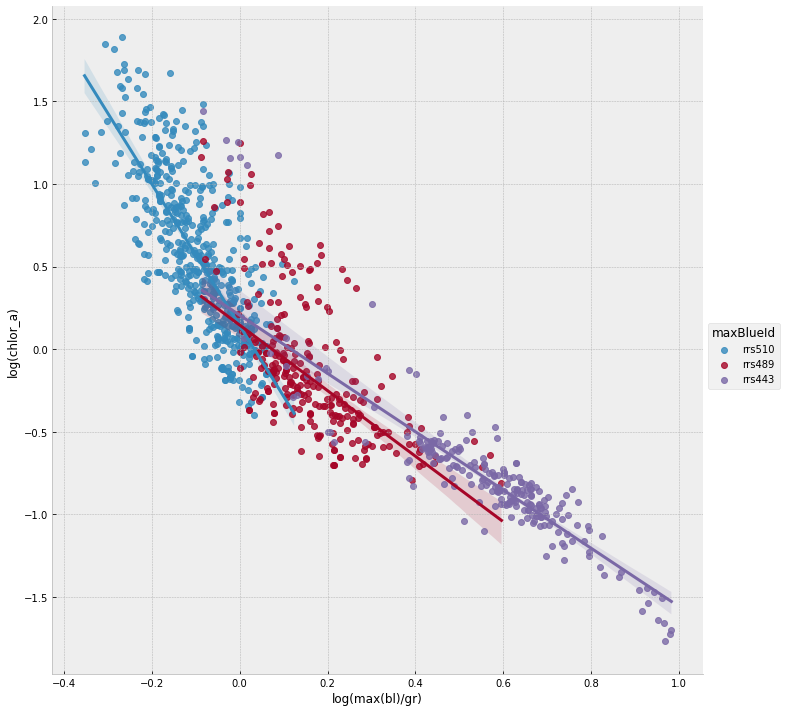

In [7]:
g = sb.lmplot(x="mxBl2Gr", y="chlor_a", hue="maxBlueId", truncate=True, size=10, data=df_train, robust=True)

# Use more informative axis labels than are provided by default
g.set_axis_labels("log(max(bl)/gr)", "log(chlor_a)")

While there is some overlap between clusters, these nevertheless seem well defined, and the progression of lower chlorophyll to higher chlorophyll follows a predictable rrs443$\rightarrow$rrs490$\rightarrow$rrs-510 progression. This suggests a couple of lines of inquiry for this post:
* Whether cluster-specific intercepts are significantly different
* Whether cluster-specific slopes are significantly different
* The figure suggests that within a single cluster a 4th order polynomial may be overkill. 
In order to index into each cluster, I have to create a 0-indexed numerical category column of *maxBlueId*:

In [8]:
df_train['max_blue_id_cat'] = df_train.maxBlueId.astype('category').cat.codes
df_train.tail()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat
4454,6901,-0.111150,rrs510,0.665378,2
4455,6902,-0.053143,rrs489,0.471287,1
4456,6914,0.153314,rrs489,-0.021756,1
4457,6903,-0.097079,rrs510,0.657274,2
4458,6915,-0.176237,rrs510,0.763947,2


Now we can implement a first model, in the image of OC4 (see [previous post]()). I will use weakly regularizing priors. Note also that to save time, I precompute the polynomial imputs:

In [9]:
df_train['mxBl2Gr_2'] = df_train.mxBl2Gr**2
df_train['mxBl2Gr_3'] = df_train.mxBl2Gr**3
df_train['mxBl2Gr_4'] = df_train.mxBl2Gr**4

In [10]:
df_train.head()

,id,mxBl2Gr,maxBlueId,chlor_a,max_blue_id_cat,mxBl2Gr_2,mxBl2Gr_3,mxBl2Gr_4
0,1565,-0.267867,rrs510,1.581950,2,0.071753,-0.019220,0.005148
1,1566,-0.220457,rrs510,1.544192,2,0.048601,-0.010714,0.002362
2,1567,-0.268537,rrs510,1.429914,2,0.072112,-0.019365,0.005200
3,1568,-0.279976,rrs510,1.680879,2,0.078386,-0.021946,0.006144
4,1559,-0.167733,rrs510,1.371991,2,0.028134,-0.004719,0.000792


In [11]:
df_train.max_blue_id_cat.unique().size
x_input = df_train.as_matrix(columns=['mxBl2Gr%s' %i for i in ['', '_2','_3','_4']])
cl_idx = df_train.max_blue_id_cat.values

In [75]:
# verify cluster index content
np.unique(cl_idx)

array([0, 1, 2], dtype=int8)

In [77]:
x_input.shape

(1016, 4)

In [73]:
# check the right columns were grabbed
x_input[:3]

array([[-0.26786697,  0.07175271, -0.01922018,  0.00514845],
       [-0.22045677,  0.04860119, -0.01071446,  0.00236208],
       [-0.26853699,  0.07211211, -0.01936477,  0.00520016]])

### Varying Intercepts

A regression problem, where the data can be split into clusters, can be be given an improved solution by computing cluster-specific regression parameters. Varying intercepts is one such approach, where the clusters share a common slope but the intercepts are cluster-specific. The model below shows this approach.

In [21]:
n_clusters = df_train.max_blue_id_cat.unique().size
clust_idx = df_train.max_blue_id_cat.values

with pm.Model() as m_vi:
    
    # priors
    alpha_clust = pm.Normal('alpha', mu=0, sd=10, shape=n_clusters)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 2)
    
    # deterministic form of the model
    mu_ = alpha_clust[clust_idx] + beta * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.Normal('chlor_a', mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_vi = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 6000/6000 [00:13<00:00, 448.22it/s]


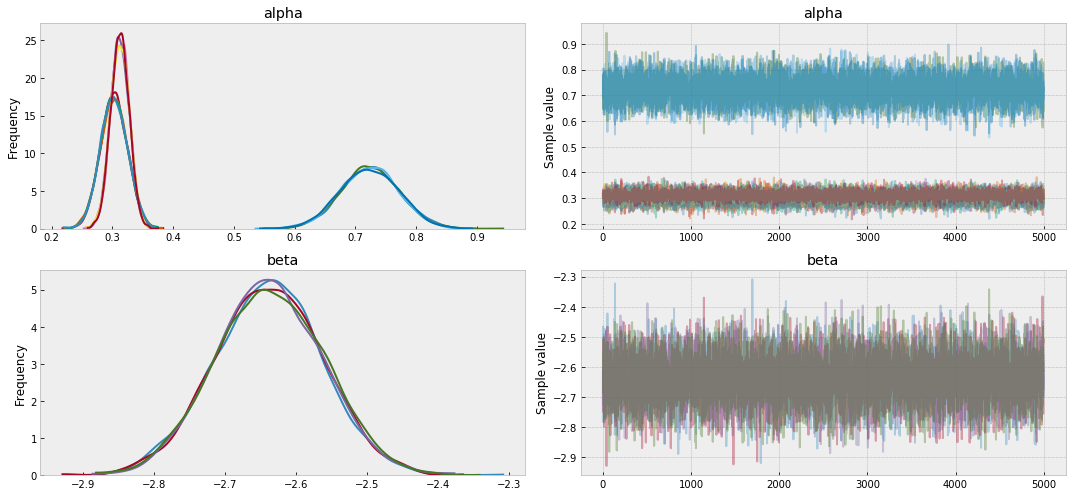

In [25]:
pm.traceplot(trace_m_vi, varnames=['alpha', 'beta'], figsize=(15, 7));

### Varying Effects:

The traces above show that one cluster has a significantly different intercept. However the single slope may hinder the inference. Model flexibility can be added by incorporating cluster-specific slopes as well. The presence of both group-based slopes and group-based intercepts is referred to by the more general term of *varying effects*

The implementation of varying effects is shown below:

In [31]:
with pm.Model() as m_ve:
    
    # priors
    alpha_clust = pm.Normal('alpha', mu=0, sd=1, shape=n_clusters)
    beta = pm.Normal('beta', mu=0, sd=1, shape=n_clusters)
    sigma = pm.HalfCauchy('sigma', 2)
    
    # deterministic form of the model
    mu_ = alpha_clust[clust_idx] + beta[clust_idx] * df_train.mxBl2Gr.values
    
    # likelihood
    chlor_a = pm.Normal('chlor_a', mu=mu_, sd=sigma, observed=df_train.chlor_a.values)
    
    # sample
    trace_m_ve = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 6000/6000 [00:19<00:00, 309.59it/s]


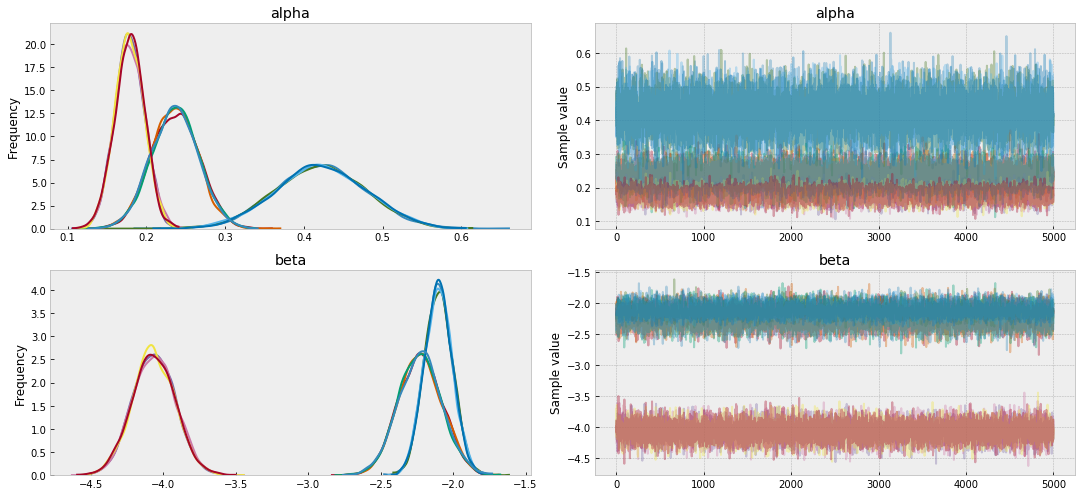

In [34]:
pm.traceplot(trace_m_ve, varnames=['alpha', 'beta'], figsize=(15, 7));

### Partial Pooling


### Gaussian Processes
